>The submission was scored on the basis of accuracy. 

## Imports 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV


In [2]:
train_data = pd.read_csv('../input/janatahack-healthcare-analytics-ii-dataset/train.csv')
test_data = pd.read_csv('../input/janatahack-healthcare-analytics-ii-dataset/test.csv')
combined = [train_data,test_data]
train_data

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.0,86499,23.0,Emergency,Moderate,3,41-50,4144.0,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.0,325,8.0,Urgent,Moderate,4,81-90,6699.0,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.0,125235,10.0,Emergency,Minor,3,71-80,4235.0,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.0,91081,8.0,Trauma,Minor,5,11-20,3761.0,11-20


> Since the target column is having categorical values, we need to convert them into discrete values

In [3]:
le = LabelEncoder()
train_data['Stay'] = le.fit_transform(train_data['Stay'])

In [4]:
train_data.columns

Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [6]:
train_data.describe()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit,Stay
count,318438.000000,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000,318438.000000
mean,159219.500000,18.318841,4.771717,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392,2.698550
std,91925.276847,8.633755,3.102535,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254,2.150075
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000,0.000000
25%,79610.250000,11.000000,2.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000,1.000000
50%,159219.500000,19.000000,5.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000,2.000000
75%,238828.750000,26.000000,7.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000,3.000000
max,318438.000000,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000,10.000000


## Analyzing the Data

In [7]:
for dataset in combined:
    dataset.drop(['case_id','patientid'],axis = 1,inplace = True)

In [8]:
train_data[['Hospital_code','Stay']].groupby('Hospital_code').mean()

,Stay
Hospital_code,
1,3.015241
2,3.503136
3,2.344576
4,1.812903
5,2.508078
6,2.612729
7,1.833844
8,2.481845
9,2.787142


In [9]:
train_data[['City_Code_Hospital','Stay']].groupby('City_Code_Hospital').mean()

,Stay
City_Code_Hospital,
1,2.552131
2,2.883572
3,2.733568
4,2.870535
5,2.726603
6,2.695261
7,2.294476
9,2.864140
10,3.015241


In [10]:
train_data[['Hospital_type_code','Stay']].groupby('Hospital_type_code').mean()

,Stay
Hospital_type_code,
a,2.530493
b,2.862530
c,2.770031
d,2.874638
e,2.673799
f,3.054564
g,3.336217


In [11]:
train_data[['Hospital_region_code','Stay']].groupby('Hospital_region_code').mean()

,Stay
Hospital_region_code,
X,2.667382
Y,2.716339
Z,2.730111


In [12]:
train_data[['Available Extra Rooms in Hospital','Stay']].groupby('Available Extra Rooms in Hospital').count()

,Stay
Available Extra Rooms in Hospital,
0,15
1,5582
2,98311
3,91520
4,91709
5,19288
6,7786
7,2876
8,1027


In [13]:
train_data[['Available Extra Rooms in Hospital','Stay']].groupby('Available Extra Rooms in Hospital').mean()

,Stay
Available Extra Rooms in Hospital,
0,3.000000
1,3.672161
2,2.992981
3,2.750798
4,2.386265
5,2.416217
6,2.315438
7,2.121697
8,2.278481


In [14]:
train_data[['Department','Stay']].groupby('Department').mean()

,Stay
Department,
TB & Chest disease,2.582829
anesthesia,2.499949
gynecology,2.710437
radiotherapy,2.817085
surgery,3.241465


In [15]:
train_data[['Ward_Type','Stay']].groupby('Ward_Type').mean()

,Stay
Ward_Type,
P,2.090170
Q,2.293392
R,2.648667
S,3.367638
T,2.985782
U,1.666667


In [16]:
train_data[['Ward_Facility_Code','Stay']].groupby('Ward_Facility_Code').mean()

,Stay
Ward_Facility_Code,
A,2.766609
B,2.895437
C,2.294476
D,2.883572
E,2.552131
F,2.734269


In [17]:
train_data[['Type of Admission','Stay']].groupby('Type of Admission').mean()

,Stay
Type of Admission,
Emergency,2.517378
Trauma,2.905426
Urgent,2.488670


In [18]:
train_data[['Severity of Illness','Stay']].groupby('Severity of Illness').mean()


,Stay
Severity of Illness,
Extreme,3.131446
Minor,2.317717
Moderate,2.744886


In [19]:
train_data[['Visitors with Patient','Stay']].groupby('Visitors with Patient').mean()
train_data['Visitors with Patient'].nunique()

28

In [20]:
train_data[['Age','Stay']].groupby('Age').mean()


,Stay
Age,
0-10,2.390630
11-20,2.306894
21-30,2.447665
31-40,2.576282
41-50,2.720654
51-60,2.807746
61-70,2.854840
71-80,2.941272
81-90,3.339670


In [21]:
train_data['Age'] = le.fit_transform(train_data['Age'])
test_data['Age'] = le.transform(test_data['Age'])

## Feature Engineering

In [22]:
train_data['Bed Grade'] = train_data['Bed Grade'].fillna(train_data['Bed Grade'].mean()).astype(int)
test_data['Bed Grade'] = test_data['Bed Grade'].fillna(test_data['Bed Grade'].mean()).astype(int)

In [23]:

train_data[['Admission_Deposit','Stay']].groupby('Admission_Deposit').mean()
train_data['CategoricalAdmission_Deposit'] = pd.qcut(train_data['Admission_Deposit'], 5)
train_data[['CategoricalAdmission_Deposit','Stay']].groupby('CategoricalAdmission_Deposit').mean()


,Stay
CategoricalAdmission_Deposit,
"(1799.999, 4051.0]",3.177736
"(4051.0, 4528.0]",2.694977
"(4528.0, 4968.0]",2.495455
"(4968.0, 5611.0]",2.439546
"(5611.0, 11008.0]",2.684753


In [24]:
train_data.loc[train_data['Admission_Deposit'] <= 4051,'Admission_Deposit'] = 0
train_data.loc[(train_data['Admission_Deposit'] > 4051) & (train_data['Admission_Deposit'] <= 4528),'Admission_Deposit'] = 1
train_data.loc[(train_data['Admission_Deposit'] > 4528) & (train_data['Admission_Deposit'] <= 4968),'Admission_Deposit'] = 2
train_data.loc[(train_data['Admission_Deposit'] > 4968) & (train_data['Admission_Deposit'] <= 5611),'Admission_Deposit'] = 3
train_data.loc[(train_data['Admission_Deposit'] > 5611) & (train_data['Admission_Deposit'] <= 11008),'Admission_Deposit'] = 4

In [25]:
test_data.loc[test_data['Admission_Deposit'] <= 4051,'Admission_Deposit'] = 0
test_data.loc[(test_data['Admission_Deposit'] > 4051) & (test_data['Admission_Deposit'] <= 4528),'Admission_Deposit'] = 1
test_data.loc[(test_data['Admission_Deposit'] > 4528) & (test_data['Admission_Deposit'] <= 4968),'Admission_Deposit'] = 2
test_data.loc[(test_data['Admission_Deposit'] > 4968) & (test_data['Admission_Deposit'] <= 5611),'Admission_Deposit'] = 3
test_data.loc[(test_data['Admission_Deposit'] > 5611) & (test_data['Admission_Deposit'] <= 11008),'Admission_Deposit'] = 4

In [26]:
train_data.drop('CategoricalAdmission_Deposit',axis = 1,inplace = True)

In [27]:
for dataset in combined:
    dataset['City_Code_Patient'].fillna(8.0,inplace = True)

In [28]:
for dataset in combined:
    dataset['City_Code_Patient'] = dataset['City_Code_Patient'].astype(int)

In [29]:
train_data['Admission_Deposit'] = train_data['Admission_Deposit'].astype(int)
train_data

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,c,3,Z,3,radiotherapy,R,F,2,7,Emergency,Extreme,2,5,2,0
1,2,c,5,Z,2,radiotherapy,S,F,2,7,Trauma,Extreme,2,5,4,4
2,10,e,1,X,2,anesthesia,S,E,2,7,Trauma,Extreme,2,5,2,3
3,26,b,2,Y,2,radiotherapy,R,D,2,7,Trauma,Extreme,2,5,4,4
4,26,b,2,Y,2,radiotherapy,S,D,2,7,Trauma,Extreme,2,5,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,6,a,6,X,3,radiotherapy,Q,F,4,23,Emergency,Moderate,3,4,1,1
318434,24,a,1,X,2,anesthesia,Q,E,4,8,Urgent,Moderate,4,8,4,3
318435,7,a,4,X,3,gynecology,R,F,4,10,Emergency,Minor,3,7,1,1
318436,11,b,2,Y,3,anesthesia,Q,D,3,8,Trauma,Minor,5,1,0,1


In [30]:
test_data['Admission_Deposit'] = test_data['Admission_Deposit'].astype(int)
test_data

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,21,c,3,Z,3,gynecology,S,A,2,2,Emergency,Moderate,2,7,0
1,29,a,4,X,2,gynecology,S,F,2,2,Trauma,Moderate,4,7,0
2,26,b,2,Y,3,gynecology,Q,D,4,2,Emergency,Moderate,3,7,1
3,6,a,6,X,3,gynecology,Q,F,2,2,Trauma,Moderate,3,7,1
4,28,b,11,X,2,gynecology,R,F,2,2,Trauma,Moderate,4,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137052,11,b,2,Y,4,anesthesia,Q,D,3,3,Emergency,Minor,4,4,4
137053,25,e,1,X,2,radiotherapy,R,E,4,7,Emergency,Moderate,2,0,0
137054,30,c,3,Z,2,anesthesia,R,A,4,12,Urgent,Minor,2,0,4
137055,5,a,1,X,2,anesthesia,R,E,4,10,Trauma,Minor,2,4,3


In [31]:
cat_features = train_data.select_dtypes(['object']).columns
cat_features

Index(['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type',
       'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness'],
      dtype='object')

In [32]:
train_data = pd.get_dummies(train_data,columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type',
       'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness'])

In [33]:
test_data = pd.get_dummies(test_data,columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type',
       'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness'])

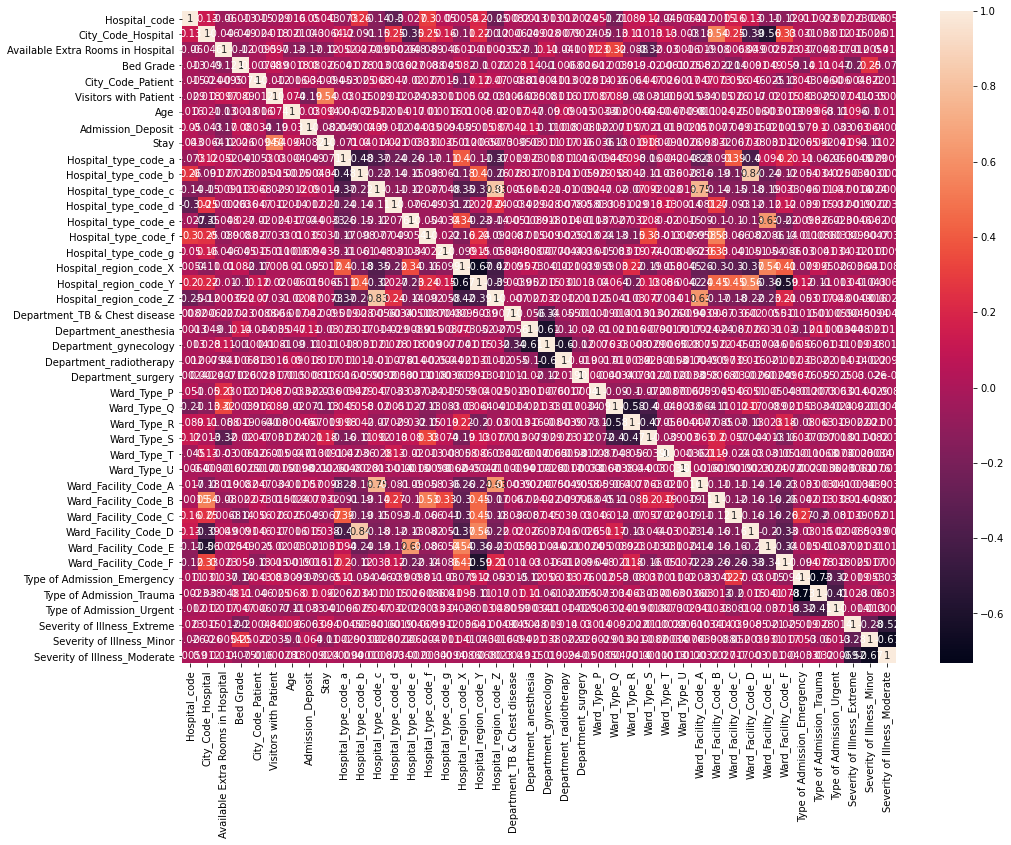

In [34]:
plt.figure(figsize = (16,12))
sns.heatmap(train_data.corr(),annot=True,cbar = True)
plt.show()

In [35]:
y_train = train_data.loc[:,'Stay']
x_train = train_data.drop('Stay',axis = 1)
x_train

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,City_Code_Patient,Visitors with Patient,Age,Admission_Deposit,Hospital_type_code_a,Hospital_type_code_b,...,Ward_Facility_Code_C,Ward_Facility_Code_D,Ward_Facility_Code_E,Ward_Facility_Code_F,Type of Admission_Emergency,Type of Admission_Trauma,Type of Admission_Urgent,Severity of Illness_Extreme,Severity of Illness_Minor,Severity of Illness_Moderate
0,8,3,3,2,7,2,5,2,0,0,...,0,0,0,1,1,0,0,1,0,0
1,2,5,2,2,7,2,5,4,0,0,...,0,0,0,1,0,1,0,1,0,0
2,10,1,2,2,7,2,5,2,0,0,...,0,0,1,0,0,1,0,1,0,0
3,26,2,2,2,7,2,5,4,0,1,...,0,1,0,0,0,1,0,1,0,0
4,26,2,2,2,7,2,5,3,0,1,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,6,6,3,4,23,3,4,1,1,0,...,0,0,0,1,1,0,0,0,0,1
318434,24,1,2,4,8,4,8,4,1,0,...,0,0,1,0,0,0,1,0,0,1
318435,7,4,3,4,10,3,7,1,1,0,...,0,0,0,1,1,0,0,0,1,0
318436,11,2,3,3,8,5,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0


## Prediction using XGBClassifier

In [36]:
clf = OneVsRestClassifier(XGBClassifier()).fit(x_train, y_train)

In [37]:
clf.score(x_train,y_train)

0.45806090981603953

In [38]:
y_pred = clf.predict(test_data)
y_pred

array([0, 5, 2, ..., 1, 1, 5])

## Submitting the predictions

In [39]:
sub = pd.DataFrame(y_pred,columns = ['Stay'],index = [i + 318439 for i in range(test_data.shape[0])])

sub.index.name = 'case_id'

In [40]:
map_dict = {
    0: '0-10',
    1: '11-20',
    2: '21-30',
    3: '31-40',
    4: '41-50',
    5: '51-60',
    6: '61-70',
    7: '71-80',
    8: '81-90',
    9: '91-100',
    10: 'More than 100 Days'
}
sub['Stay'] = sub['Stay'].map(map_dict)
sub

,Stay
case_id,
318439,0-10
318440,51-60
318441,21-30
318442,21-30
318443,51-60
...,...
455491,21-30
455492,0-10
455493,11-20


In [41]:
sub.to_csv('latest.csv')